In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore','.*')

In [3]:
from IPython import display

In [4]:
import cStringIO as StringIO
from PIL import Image

In [5]:
import numpy as np
import matplotlib.pyplot as pl
from path import Path
import pandas as pd
import cv2

In [6]:
import theano
import theano.tensor as T
import lasagne

Using gpu device 0: GeForce GTX 660 Ti


In [34]:
import pydnn
import pyimg
from pydnn.models.pseudofcn import PseudoFcn8_2
from pydnn.expr2d import masked_error_rate_2d

In [35]:
#Creating list to store the path of image and structured_labes
image_frame = []
gt_image_frame = []

In [36]:
#Base directory where data is available
base_dir = Path('/home/aeroscout2/data/NYUv2/')

In [10]:
# Getting all the pathes of files reading frome each directory
for i in xrange(0,1200):
    dir_num = "%05d" % i     
    base_dir_current = base_dir + str(dir_num)
    image_frame.append(base_dir_current.files('image.jpg'))
    gt_image_frame.append(base_dir_current.files('structure_labels.png')) 

print 'Length of image_frame:', image_frame.__len__()
print 'Length of gt_image_frame:', gt_image_frame.__len__()

Length of image_frame: 1200
Length of gt_image_frame: 1200


In [11]:
image_frames = sum(image_frame,[])
gt_image_frames = sum(gt_image_frame,[])
print 'Length of image_frames:', image_frames.__len__()
print 'Length of image_frames:', gt_image_frames.__len__()
#image_frames = image_frames[:1449]
#gt_image_frames = gt_image_frames[:1449]
N = len(image_frames)
rng = np.random.RandomState(seed=28)
shuffle_idx = rng.permutation(N)
train_idx, test_idx = shuffle_idx[:-4], shuffle_idx[-4:]
#print len(train_idx), len(test_idx)

Length of image_frames: 1200
Length of image_frames: 1200


In [12]:
N_train = len(train_idx)
N_test = len(test_idx)

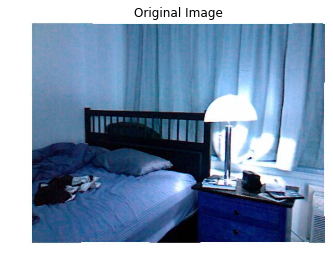

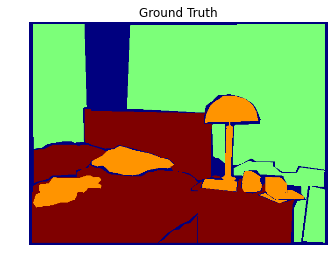

In [13]:
img = cv2.imread(image_frames[80])
gt_img = cv2.imread(gt_image_frames[80], cv2.IMREAD_UNCHANGED)
pl.imshow(img); pl.axis('off'); pl.title('Original Image'); pl.show();
pl.imshow(gt_img); pl.axis('off'); pl.title('Ground Truth'); pl.show();

In [14]:
label_df = 5 #number of categories with void
batch_size = 8
num_class = label_df-1 #Acutal number of classes
model = PseudoFcn8_2(batch_size, num_class)


In [15]:
H, W = model.input_height, model.input_width # H=227, W = 227
h, w = model.l_out.get_output_shape()[2:]  # h=27, w=27
X_data = np.zeros((N, 3, H, W), dtype=np.float32)
y_data = np.zeros((N, 1, h, w), dtype=np.float32)

In [16]:
model.l_out.get_output_shape() # Shape of final output with batch_size=8


(8, 4, 27, 27)

In [17]:
img_jit = pydnn.preprocessing.ImageBatchJitterer(x_output_shape=(H,W), y_output_shape=(h,w))
#x_output_shape= (227,227)
#y_output_shape = (27,27)

In [18]:
for n in xrange(N):
    img = cv2.imread(image_frames[n])
    img = np.asarray(cv2.resize(img,(H,W), fx = 0, fy = 0, interpolation = cv2.INTER_LINEAR)).copy()
    gt_img = cv2.imread(gt_image_frames[n],cv2.IMREAD_UNCHANGED)
    gt_img = np.asarray(cv2.resize(gt_img,(w, h), fx=0, fy=0, interpolation=cv2.INTER_NEAREST)).copy()#image.nearest   
    X_data[n] = np.rollaxis(img, 2).astype(np.float32)  # shape is (240,3,227,227) 
    y_data[n,0] = np.asarray(gt_img).astype(np.float32) #shape is (240,1,27,27)

print 'X_data Shape:', X_data.shape
print 'y_data Shape:', y_data.shape

X_data Shape: (1200, 3, 227, 227)
y_data Shape: (1200, 1, 27, 27)


In [19]:
mean_px = X_data[train_idx].mean((0, 2, 3), keepdims=True) #Calculating the mean of pixel value

In [20]:
mean_px.shape, mean_px

((1, 3, 1, 1), array([[[[ 69.69104004]],
 
         [[ 69.69104004]],
 
         [[ 69.69104004]]]], dtype=float32))

In [21]:
X_data -= mean_px

In [22]:
X_data_j, y_data_j = img_jit.preprocess(X_data[train_idx], y_data[train_idx]) # preprocessing training data
print 'Shape of X_data_j :', X_data_j.shape
print 'Shape of y_data_j :', y_data_j.shape

Shape of X_data_j : (1196, 3, 227, 227)
Shape of y_data_j : (1196, 1, 27, 27)


In [23]:
X_shared = theano.shared(X_data_j) # Creating the theano shared variable
y_shared = theano.shared(y_data_j)

In [24]:
#Defining Theano varaibles
X_batch = model.X
y_batch = model.y1 
batch_index = T.iscalar('b_ix')
batch_slice = slice(batch_index*model.batch_size, (batch_index+1)*batch_size)


In [25]:
#Defining outputs 
out = model.l_out.get_output(X_batch) # ??(predicted output) // the FCN is called here
dout = model.l_out.get_output(X_batch, deterministic = True) #difference b/w both outputs


/home/aeroscout2/mavscout_semantic/src/pydnn/python/pydnn/layers/alexnet_layers.py:129: DeprecationWarning: Division of two integer types with x / y is deprecated, please use x // y for an integer division.
  dnn.dnn_conv(img=input[:, :input_channels / 2, :, :],
/home/aeroscout2/mavscout_semantic/src/pydnn/python/pydnn/layers/alexnet_layers.py:135: DeprecationWarning: Division of two integer types with x / y is deprecated, please use x // y for an integer division.
  conv_out1 = dnn.dnn_conv(img=input[:, input_channels / 2:, :, :],
/home/aeroscout2/mavscout_semantic/src/pydnn/python/pydnn/layers/alexnet_layers.py:129: DeprecationWarning: Division of two integer types with x / y is deprecated, please use x // y for an integer division.
  dnn.dnn_conv(img=input[:, :input_channels / 2, :, :],
/home/aeroscout2/mavscout_semantic/src/pydnn/python/pydnn/layers/alexnet_layers.py:135: DeprecationWarning: Division of two integer types with x / y is deprecated, please use x // y for an integer di

In [26]:
#Defining loss
loss = model.get_loss(out, y_batch) + 0.0005*model.get_l2_norm()


In [27]:
#Getting and updating all the paramters of model
all_params = model.get_params()
updates = lasagne.updates.momentum(loss, all_params, 0.0001, 0.9)
print 'All parameters of model:\n', all_params

All parameters of model:
[conv1.W, conv1.b, conv1_nin.W, conv1_nin.b, conv2.W0, conv2.W1, conv2.b0, conv2.b1, conv3.W, conv3.b, conv4.W0, conv4.W1, conv4.b0, conv4.b1, conv4_nin.W, conv4_nin.b, conv5.W0, conv5.W1, conv5.b0, conv5.b1, conv6.W, conv6.b, conv7.W, conv7.b, conv7_nin.W, conv7_nin.b, conv_out_nin.W, conv_out_nin.b]


In [28]:
pred_fn = theano.function([batch_index], model.get_prediction_image(dout), givens={X_batch: X_shared[batch_slice]})

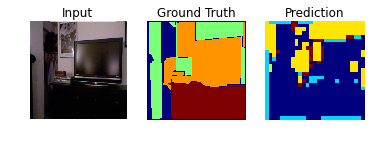

[0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0
 2 2 2 2 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 3 3 3 3 3 3 0 0]
[3 2 2 2 2 2 2 4 4 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


In [29]:
yi = 0
X_data_j, y_data_j = img_jit.preprocess(X_data[test_idx], y_data[test_idx], deterministic=True)
X_shared.set_value(X_data_j, borrow=True)
y_shared.set_value(y_data_j, borrow=True)
yhat_b = pred_fn(0) # output shape=(4,1,27,27)
yhat00 = yhat_b[yi,0]+1  # why adding one ?
img = np.asarray(Image.open(image_frames[test_idx[yi]]).resize((256, 256)))
gt_img = np.asarray(Image.open(gt_image_frames[test_idx[yi]]).resize((256, 256)))
pl.subplot(1, 3, 1)
pl.imshow(img); pl.axis('off'); pl.title('Input'); 
pl.subplot(1, 3, 2)
pl.imshow(gt_img, interpolation='nearest'); pl.axis('off'); pl.title('Ground Truth')
pl.subplot(1, 3, 3)
pl.imshow(yhat00, interpolation='nearest'); pl.axis('off'); pl.title('Prediction')
pl.show()
print gt_img[6]
print yhat00[0]

In [30]:
#Batch training takes input batch index and gives loss as output, apply updates to loss
iter_train = theano.function([batch_index], loss, updates=updates, allow_input_downcast=True,
                            givens={X_batch: X_shared[batch_slice], y_batch: T.cast(y_shared[batch_slice], 'int32')})  

In [31]:
num_batches = N//batch_size
num_batches

150

In [32]:
for epoch in xrange(10):
    X_data_j, y_data_j = img_jit.preprocess(X_data, y_data)
    X_shared.set_value(X_data_j, borrow=True)
    y_shared.set_value(y_data_j, borrow=True)
    losses = []
    for bi in xrange(num_batches):
        losses.append(iter_train(bi))
        #print('loss: {}'.format(loss_value))
    print('epoch {}, average loss: {} \n'.format(epoch, np.mean(losses))),

epoch 0, average loss: 5.9861240387 
epoch 1, average loss: 4.72866296768 
epoch 2, average loss: 4.51901865005 
epoch 3, average loss: 4.44378185272 
epoch 4, average loss: 4.39591646194 
epoch 5, average loss: 4.38533306122 
epoch 6, average loss: 4.32904052734 
epoch 7, average loss: 4.30231618881 
epoch 8, average loss: 4.28736686707 
epoch 9, average loss: 4.26244926453 


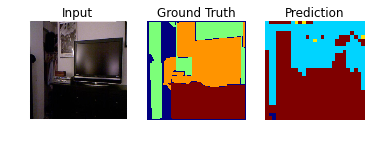

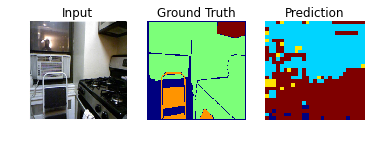

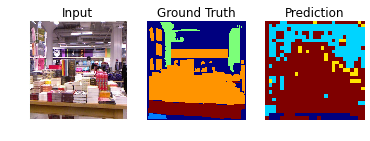

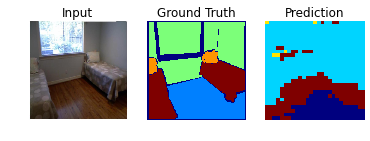

In [33]:
    for yi in xrange(len(test_idx)):    
        X_data_j, y_data_j = img_jit.preprocess(X_data[test_idx], y_data[test_idx], deterministic=True)
        X_shared.set_value(X_data_j, borrow=True)
        y_shared.set_value(y_data_j, borrow=True)
        yhat_b = pred_fn(0) #testing is also batch type
        yhat00 = yhat_b[yi,0]+1
        img = np.asarray(Image.open(image_frames[test_idx[yi]]).resize((256, 256)))
        gt_img = np.asarray(Image.open(gt_image_frames[test_idx[yi]]).resize((256, 256)))
        pl.subplot(1, 3, 1)
        pl.imshow(img); pl.axis('off'); pl.title('Input'); 
        pl.subplot(1, 3, 2)
        pl.imshow(gt_img, interpolation='nearest'); pl.axis('off'); pl.title('Ground Truth')
        pl.subplot(1, 3, 3)
        pl.imshow(yhat00, interpolation='nearest'); pl.axis('off'); pl.title('Prediction')
        pl.show()

In [42]:
print yhat00.shape
#error = masked_error_rate_2d(yhat00,y_data[0])
#print 'Pixel wise error is :', error
layers = lasagne.layers.helper.get_all_layers(model.l_out)

(27, 27)


In [35]:
for layer in layers:
    print layer.name, layer.get_output_shape()

None (8, 3, 227, 227)
conv1 (8, 96, 27, 27)
conv1_nin (8, 512, 27, 27)
conv2 (8, 256, 13, 13)
conv3 (8, 384, 13, 13)
conv4 (8, 384, 13, 13)
conv4_nin (8, 512, 13, 13)
None (8, 512, 13, 13)
conv5 (8, 256, 6, 6)
conv6 (8, 4096, 5, 5)
conv7 (8, 4096, 5, 5)
None (8, 4096, 5, 5)
conv7_nin (8, 512, 5, 5)
conv7_nin_up (8, 512, 10, 10)
None (8, 512, 14, 14)
None (8, 512, 13, 13)
fcn16 (8, 512, 13, 13)
fcn16_up (8, 512, 26, 26)
None (8, 512, 28, 28)
None (8, 512, 27, 27)
None (8, 512, 27, 27)
None (8, 512, 27, 27)
conv_out_nin (8, 4, 27, 27)
